# **Image Colorization using Autoencoders.** 

## 1 . Download and split files.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Download and unzip (2.2GB)
!mkdir /content/drive/My\ Drive/places-data
!wget -O /content/drive/My\ Drive/places-data/testSetPlaces205_resize.tar.gz http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz


--2020-05-24 06:47:58--  http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.129.40
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.129.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2341250899 (2.2G) [application/octet-stream]
Saving to: ‘/content/drive/My Drive/places-data/testSetPlaces205_resize.tar.gz’

/content/drive/My D 100%[===================>]   2.18G  11.5MB/s    in 1m 56s  

2020-05-24 06:49:55 (19.2 MB/s) - ‘/content/drive/My Drive/places-data/testSetPlaces205_resize.tar.gz’ saved [2341250899/2341250899]



In [0]:
!tar -xzf /content/drive/My\ Drive/places-data/testSetPlaces205_resize.tar.gz

In [0]:
# Move data into training and validation directories
import os
os.makedirs('images/train/class/', exist_ok=True) # 40,000 images
os.makedirs('images/val/class/', exist_ok=True)   #  1,000 images
for i, file in enumerate(os.listdir('testSet_resize')):
  if i < 1000: # first 1000 will be val
    os.rename('testSet_resize/' + file, 'images/val/class/' + file)
  else: # others will be val
    os.rename('testSet_resize/' + file, 'images/train/class/' + file)

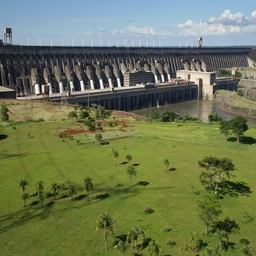

In [4]:
from google.colab.patches import cv2_imshow
import cv2
img = os.listdir('images/train/class')
img = cv2.imread('images/train/class/'+img[3])
cv2_imshow(img)

## 2. Network Architecture

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
from torchvision import datasets, transforms

import os, shutil, time

In [6]:
# Check if GPU is available
use_gpu = torch.cuda.is_available()
if use_gpu:
  print("GPU Available.")
else: print("Training on CPU.")

GPU Available.


### - Checking Resnet layers

In [0]:
resnet = models.resnet18() 
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
nn.Sequential(*list(resnet.children())[0:6])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

### - Main network

In [0]:
class ColorizationUpsampling(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationUpsampling, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## Encoder
    resnet = models.resnet18()
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, x):
    ## Encoder
    x = self.midlevel_resnet(x)
    ## Decoder
    x = self.upsample(x)
    return x

In [0]:
model = ColorizationUpsampling()

In [0]:
# specify loss function
criterion = nn.MSELoss()
# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## 3. Utility and Data Loaders.

In [0]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      gray = rgb2gray(img_original)
      gray = torch.from_numpy(gray).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return gray, img_ab, target

In [0]:
# Training
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('images/train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

# Validation 
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder('images/val' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

## 4. Helper function.

In [0]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

## 5. Validation function.

In [0]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg

## 6. Training function.

In [0]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: 
      input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

## 7. Train Model 

In [20]:
model.load_state_dict(torch.load('/content/drive/My Drive/colorization_models/checkpoints/model-epoch-18-losses-0.003.pth' ))


<All keys matched successfully>

In [0]:
# Move model and loss function to GPU
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()

In [0]:
# Make folders and set parameters
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
#os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 100000
epochs = 100

In [23]:
# Train model
for epoch in range(18, epochs):
  # Train for one epoch, then validate
  train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_loader, model, criterion, save_images, epoch)
  # Save checkpoint and replace old best model if current model is better
  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(), '/content/drive/My Drive/colorization_models/checkpoints/model-epoch-{}-losses-{:.6f}.pth'.format(epoch+1,losses))

Starting training epoch 18
Epoch: [18][0/625]	Time 1.880 (1.880)	Data 1.622 (1.622)	Loss 0.0026 (0.0026)	
Epoch: [18][25/625]	Time 1.691 (1.712)	Data 1.535 (1.554)	Loss 0.0030 (0.0030)	
Epoch: [18][50/625]	Time 1.687 (1.706)	Data 1.533 (1.549)	Loss 0.0027 (0.0030)	
Epoch: [18][75/625]	Time 1.688 (1.705)	Data 1.531 (1.548)	Loss 0.0029 (0.0029)	
Epoch: [18][100/625]	Time 1.707 (1.696)	Data 1.550 (1.540)	Loss 0.0032 (0.0029)	
Epoch: [18][125/625]	Time 1.674 (1.690)	Data 1.519 (1.534)	Loss 0.0031 (0.0029)	
Epoch: [18][150/625]	Time 1.659 (1.685)	Data 1.502 (1.529)	Loss 0.0032 (0.0028)	
Epoch: [18][175/625]	Time 1.647 (1.682)	Data 1.491 (1.526)	Loss 0.0029 (0.0029)	
Epoch: [18][200/625]	Time 1.649 (1.679)	Data 1.496 (1.523)	Loss 0.0027 (0.0029)	
Epoch: [18][225/625]	Time 1.676 (1.677)	Data 1.522 (1.521)	Loss 0.0024 (0.0029)	
Epoch: [18][250/625]	Time 1.659 (1.675)	Data 1.503 (1.519)	Loss 0.0026 (0.0028)	
Epoch: [18][275/625]	Time 1.641 (1.673)	Data 1.486 (1.517)	Loss 0.0026 (0.0028)	
Epoch:

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

## 8. Predictions

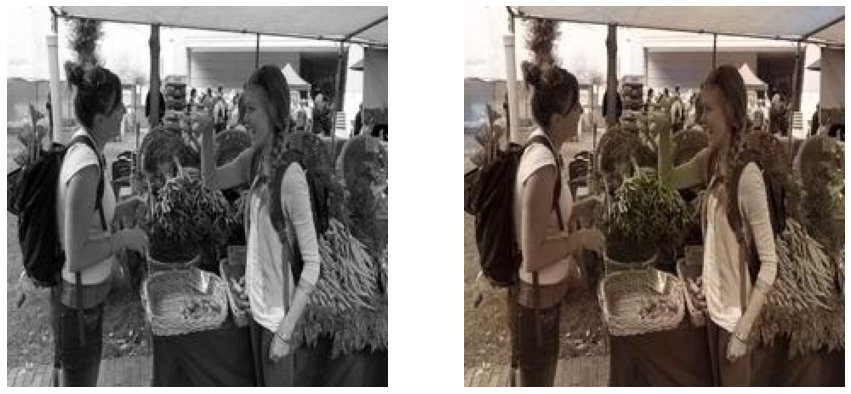

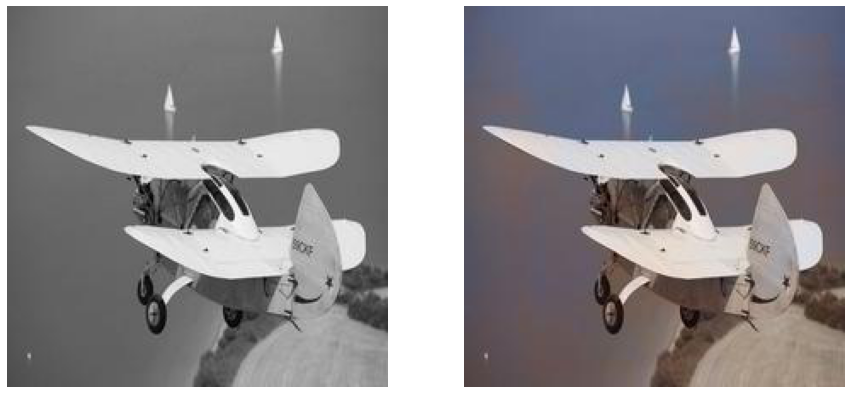

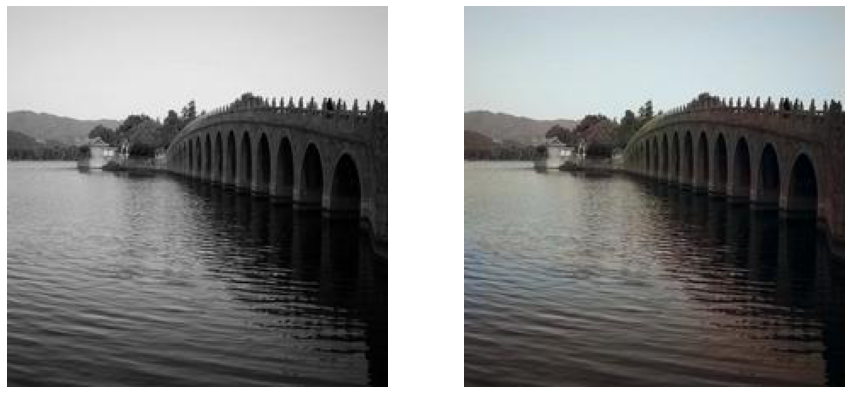

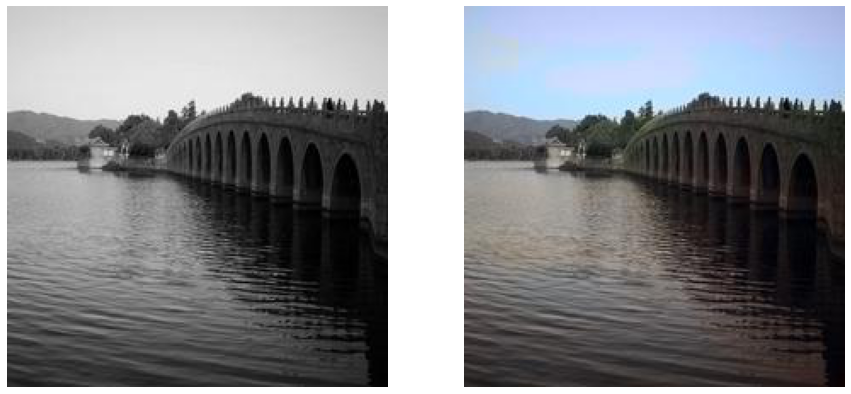

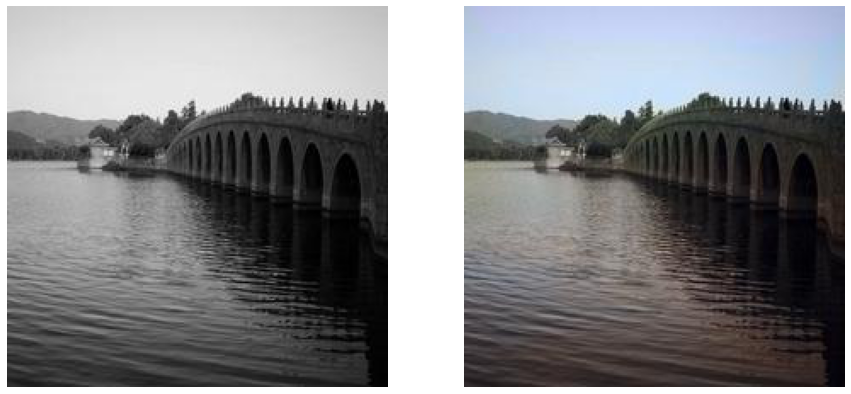

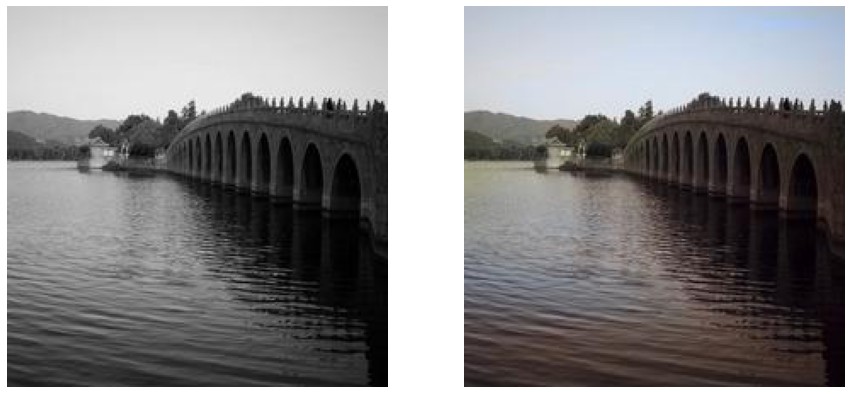

In [29]:
# Show images 
import matplotlib.image as mpimg
image_pairs = [('outputs/color/img-2-epoch-28.jpg', 'outputs/gray/img-2-epoch-28.jpg'),
               ('outputs/color/img-6-epoch-28.jpg', 'outputs/gray/img-6-epoch-28.jpg'),
               ('outputs/color/img-8-epoch-22.jpg', 'outputs/gray/img-8-epoch-22.jpg'),
               ('outputs/color/img-8-epoch-29.jpg', 'outputs/gray/img-8-epoch-29.jpg'),
               ('outputs/color/img-8-epoch-36.jpg', 'outputs/gray/img-8-epoch-36.jpg'),
               ('outputs/color/img-8-epoch-38.jpg', 'outputs/gray/img-8-epoch-38.jpg')]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()

In [0]:
li = os.listdir("outputs/color")
li

['img-5-epoch-0.jpg',
 'img-4-epoch-0.jpg',
 'img-6-epoch-0.jpg',
 'img-9-epoch-0.jpg',
 'img-3-epoch-0.jpg',
 'img-1-epoch-0.jpg',
 'img-0-epoch-0.jpg',
 'img-2-epoch-0.jpg',
 'img-8-epoch-0.jpg',
 'img-7-epoch-0.jpg']

In [30]:
!zip -r output_file.zip outputs/

  adding: outputs/ (stored 0%)
  adding: outputs/color/ (stored 0%)
  adding: outputs/color/img-7-epoch-29.jpg (deflated 2%)
  adding: outputs/color/img-3-epoch-24.jpg (deflated 1%)
  adding: outputs/color/img-3-epoch-27.jpg (deflated 1%)
  adding: outputs/color/img-5-epoch-27.jpg (deflated 1%)
  adding: outputs/color/img-9-epoch-24.jpg (deflated 1%)
  adding: outputs/color/img-9-epoch-20.jpg (deflated 1%)
  adding: outputs/color/img-2-epoch-32.jpg (deflated 1%)
  adding: outputs/color/img-1-epoch-32.jpg (deflated 1%)
  adding: outputs/color/img-0-epoch-25.jpg (deflated 1%)
  adding: outputs/color/img-5-epoch-31.jpg (deflated 1%)
  adding: outputs/color/img-9-epoch-34.jpg (deflated 1%)
  adding: outputs/color/img-1-epoch-37.jpg (deflated 2%)
  adding: outputs/color/img-3-epoch-31.jpg (deflated 1%)
  adding: outputs/color/img-0-epoch-26.jpg (deflated 1%)
  adding: outputs/color/img-6-epoch-29.jpg (deflated 2%)
  adding: outputs/color/img-2-epoch-28.jpg (deflated 1%)
  adding: outputs/co